## Abstract

 This paper aims to apply a Machine Learning classifier to Mexican Death records in other to improve classification. 

In [1]:
import pandas as pd
import numpy as np
import re, string, os, torch, nltk, itertools, spacy
from unidecode import unidecode
from tqdm import tqdm 
tqdm.pandas()

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AdamW, get_scheduler
import torch.nn as nn
import torch.optim as optim


from spellchecker import SpellChecker
from functools import lru_cache

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Helpers functions

In [2]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, using CPU instead.")


1 Physical GPUs, 1 Logical GPU


2024-08-24 11:22:56.101112: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-24 11:22:56.101150: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-08-24 11:22:56.101156: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-08-24 11:22:56.101238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-24 11:22:56.101528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
from gensim.models.fasttext import load_facebook_model
from gensim.models import Word2Vec

## B. Preprocess functions for generating embedding
def preprocess_text(text):
    """Preprocess text by removing special characters and applying unidecode."""
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = unidecode(text)  # Normalize text
    return text.lower()

def tokenize_and_preprocess(text_column):
    """Tokenize and preprocess all texts in the given column."""
    return [word_tokenize(preprocess_text(text)) for text in text_column]

def train_word2vec(sentences, vector_size=100, window=5, min_count=1, sg=0):
    """Train a Word2Vec CBOW model."""
    return Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg)

### Load glove model
def load_glove_model1(file_path):
    glove_model = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            if len(parts) > 2:  # Check if the line has more than just a word and one number
                word = parts[0]
                try:
                    vector = [float(x) for x in parts[1:]]
                    glove_model[word] = vector
                except ValueError:
                    print(f"Skipping line with invalid format: {line.strip()}")
    return glove_model

def load_glove_model(file_path):
    """Loads GloVe model from a file."""
    glove_model = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe Model"):
            parts = line.split()
            word = parts[0]
            vector = [float(x) for x in parts[1:]]
            glove_model[word] = vector
    return glove_model

#Generate embeddings
def generate_embeddings(dataframe, text_column, vocabulary, glove_path, fasttext_path):
    # Tokenize and preprocess texts for Word2Vec
    tokenized_texts = tokenize_and_preprocess(dataframe[text_column])
    
    # Train Word2Vec CBOW model
    word2vec_model = train_word2vec(tokenized_texts)
    # Load GloVe and FastText models
    glove_model = load_glove_model1(glove_path)
    fasttext_model = load_facebook_model(fasttext_path)
    
    # Initialize embedding dictionaries
    glove_embeddings = {}
    fasttext_embeddings = {}
    word2vec_embeddings = {}
    
    for word in tqdm(vocabulary, desc="Generating Embeddings"):
        preprocessed_word = preprocess_text(word)
        # GloVe
        glove_embeddings[word] = glove_model.get(preprocessed_word)
        # FastText
        fasttext_embeddings[word] = fasttext_model.wv[preprocessed_word] if preprocessed_word in fasttext_model.wv else None
        # Word2Vec
        word2vec_embeddings[word] = word2vec_model.wv[preprocessed_word] if preprocessed_word in word2vec_model.wv else None
    
    return glove_embeddings, fasttext_embeddings, word2vec_embeddings


def get_mean_embedding(sentence, embeddings):
    """
    Compute the mean embedding for a sentence, ensuring all embeddings are valid and rounded to 4 decimals.
    
    :param sentence: A string representing the sentence.
    :param embeddings: The GloVe embeddings dictionary.
    :return: A PyTorch tensor representing the mean embedding, rounded to 4 decimal places.
    """
    words = sentence.lower().split()
    valid_embeddings = [embeddings[word] for word in words if word in embeddings and embeddings[word] is not None]
    
    if not valid_embeddings:
        # Assuming the dimension of your embeddings is 100
        mean_embedding = np.zeros(pd.DataFrame(embeddings).shape[0])
    else:
        mean_embedding = np.round(np.mean(valid_embeddings, axis=0), 4)
    
    return torch.tensor(mean_embedding, dtype=torch.float)

## Read data

In [12]:
df = pd.read_pickle("../Data/icd_clean.pkl")
df = df.sample(1_000, random_state=123)
data = df[['cause','causa_icd']]
label_mapping = {value: label for label, value in enumerate(data['causa_icd'].unique())}
data['label'] = data['causa_icd'].map(label_mapping)
text, label = data['cause'].values, data['label'].values
vocabulary = set([word for item in text for word in str(item).split()])

glove_path = '../../economic_thesis/data/embeddings/glove/glove.6B.300d.txt'
fasttext_path = '../../economic_thesis/data/embeddings/fasttext/cc.es.300.bin'

glove_embs, fasttext_embs, word2vec_embs = generate_embeddings(data, 'cause', vocabulary, glove_path, fasttext_path)
print("-------------------------------------------------------------")
glove_embedding = torch.stack([get_mean_embedding(sentence, glove_embs) for sentence in tqdm(data['cause'], desc="Computing GloVe embeddings")])
print("-------------------------------------------------------------")
word2_vec_embedding = torch.stack([get_mean_embedding(sentence, word2vec_embs) for sentence in tqdm(data['cause'], desc="Computing Word2vec embeddings")])
print("-------------------------------------------------------------")
fasttext_embedding = torch.stack([get_mean_embedding(sentence, fasttext_embs) for sentence in tqdm(data['cause'], desc="Computing FastText embeddings")])

/var/folders/k8/6tpfnthj2sd5t44tk2qx3f240000gn/T/ipykernel_4398/2104867647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['causa_icd'].map(label_mapping)
Generating Embeddings: 100%|██████████| 217/217 [00:00<00:00, 4106.20it/s]


-------------------------------------------------------------


Computing GloVe embeddings: 100%|██████████| 1000/1000 [00:00<00:00, 15835.57it/s]


-------------------------------------------------------------


Computing Word2vec embeddings: 100%|██████████| 1000/1000 [00:00<00:00, 56088.58it/s]


-------------------------------------------------------------


Computing FastText embeddings: 100%|██████████| 1000/1000 [00:00<00:00, 54150.10it/s]


In [13]:
# Model parameters
vocab_size = len(vocabulary)
embedding_dim = 300
max_length = 512//2
batch_size = 16
num_epochs = 10
random_state = 123
test_size = 0.2
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Sampling and preparing the data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(data['cause'])
sequences = tokenizer.texts_to_sequences(data['cause'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
labels = torch.tensor(data['label'].astype('category').cat.codes.values)

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
  padded_sequences, labels, 
  test_size=test_size, 
  random_state=random_state)

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/var/folders/k8/6tpfnthj2sd5t44tk2qx3f240000gn/T/ipykernel_4398/2115524327.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/var/folders/k8/6tpfnthj2sd5t44tk2qx3f240000gn/T/ipykernel_4398/2115524327.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


In [15]:
class BiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, embedding_matrix=None):
        super(BiGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)

        self.bigru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # hidden_dim * 2 to account for bidirectional output

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bigru(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

In [16]:
import torch.nn.functional as F
class BiGRUWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, embedding_matrix=None):
        super(BiGRUWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)

        self.bigru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Attention layer
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Fully connected layer

    def forward(self, x):
        x = self.embedding(x)
        gru_output, _ = self.bigru(x)  # Output from the BiGRU (batch_size, seq_length, hidden_dim * 2)

        # Compute attention scores
        attention_scores = torch.tanh(self.attention(gru_output))  # (batch_size, seq_length, 1)
        attention_weights = F.softmax(attention_scores, dim=1)  # Normalize scores (batch_size, seq_length, 1)

        # Create context vector
        context_vector = torch.sum(attention_weights * gru_output, dim=1)  # Weighted sum of outputs (batch_size, hidden_dim * 2)

        # Final fully connected layer
        output = self.fc(context_vector)
        return output


In [17]:
# Initialize the model
model = BiGRU(vocab_size, 100, 128, 3, 
              len(torch.unique(labels)), 
              embedding_matrix = word2_vec_embedding).to(device)
model

BiGRU(
  (embedding): Embedding(217, 100)
  (bigru): GRU(100, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=20, bias=True)
)

In [18]:
# Initialize the model
model_a = BiGRUWithAttention(vocab_size, 512, 128, 3, 
              len(torch.unique(labels)), 
              embedding_matrix = None).to(device)
model_a

BiGRUWithAttention(
  (embedding): Embedding(217, 512)
  (bigru): GRU(512, 128, num_layers=3, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=256, out_features=20, bias=True)
)

In [19]:
# for unbalanced labels use class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_dataset.tensors[1].cpu().numpy()),
                                     y=train_dataset.tensors[1].cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_a.parameters(), lr=0.001)

In [20]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    
    # Lists to store metrics for each epoch
    training_losses = []
    training_accuracy = []
    evaluation_accuracy = []
    evaluation_precision = []
    evaluation_recall = []
    evaluation_f1 = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total = 0
        correct = 0
        epoch_loss = 0
        
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            epoch_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Average loss and accuracy for the epoch
        epoch_loss /= total
        epoch_accuracy = 100 * correct / total
        training_losses.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)
        
        # Evaluation phase
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        evaluation_accuracy.append(accuracy)
        evaluation_precision.append(precision)
        evaluation_recall.append(recall)
        evaluation_f1.append(f1)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.2f}, Training Accuracy: {epoch_accuracy:.2f}%, '
              f'Evaluation Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')
    
    return training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1

training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1 = train_and_evaluate_model(
    model_a, train_loader, test_loader, criterion, optimizer, num_epochs
)


Epoch 1, Loss: 2.85, Training Accuracy: 20.25%, Evaluation Accuracy: 0.73, Precision: 0.70, Recall: 0.72, F1-Score: 0.67
Epoch 2, Loss: 0.69, Training Accuracy: 86.00%, Evaluation Accuracy: 0.83, Precision: 0.89, Recall: 0.87, F1-Score: 0.84
Epoch 3, Loss: 0.21, Training Accuracy: 91.12%, Evaluation Accuracy: 0.86, Precision: 0.88, Recall: 0.90, F1-Score: 0.87
Epoch 4, Loss: 0.13, Training Accuracy: 94.12%, Evaluation Accuracy: 0.90, Precision: 0.85, Recall: 0.89, F1-Score: 0.86
Epoch 5, Loss: 0.14, Training Accuracy: 94.88%, Evaluation Accuracy: 0.83, Precision: 0.85, Recall: 0.89, F1-Score: 0.84
Epoch 6, Loss: 0.10, Training Accuracy: 95.88%, Evaluation Accuracy: 0.90, Precision: 0.86, Recall: 0.89, F1-Score: 0.87
Epoch 7, Loss: 0.07, Training Accuracy: 97.50%, Evaluation Accuracy: 0.89, Precision: 0.86, Recall: 0.89, F1-Score: 0.87
Epoch 8, Loss: 0.05, Training Accuracy: 97.62%, Evaluation Accuracy: 0.90, Precision: 0.87, Recall: 0.89, F1-Score: 0.87
Epoch 9, Loss: 0.11, Training Ac

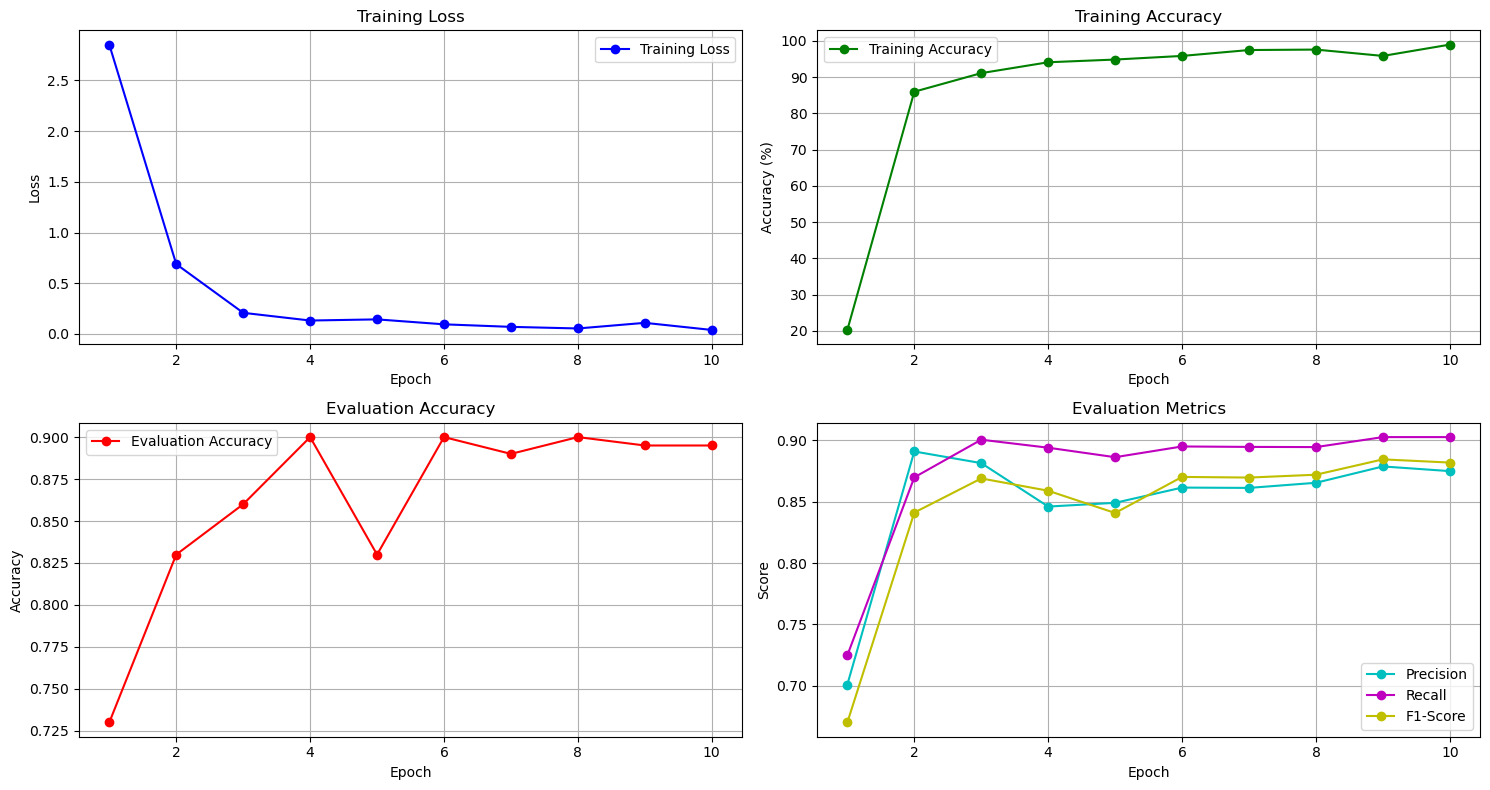

In [24]:
import matplotlib.pyplot as plt

# Create a figure for the plots
plt.figure(figsize=(15, 8))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='Training Loss', color='b')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')  # Save the training loss plot

# Plot training accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, marker='o', label='Training Accuracy', color='g')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')  # Save the training accuracy plot

# Plot evaluation accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, len(evaluation_accuracy) + 1), evaluation_accuracy, marker='o', label='Evaluation Accuracy', color='r')
plt.title('Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_accuracy.png')  # Save the evaluation accuracy plot

# Plot evaluation precision, recall, and F1-score
plt.subplot(2, 2, 4)
plt.plot(range(1, len(evaluation_precision) + 1), evaluation_precision, marker='o', label='Precision', color='c')
plt.plot(range(1, len(evaluation_recall) + 1), evaluation_recall, marker='o', label='Recall', color='m')
plt.plot(range(1, len(evaluation_f1) + 1), evaluation_f1, marker='o', label='F1-Score', color='y')
plt.title('Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_metrics.png')  # Save the evaluation metrics plot

# Adjust layout and show all plots
plt.tight_layout()
plt.show()


In [25]:
import pickle
# Save the model's state dictionary
torch.save(model_a.state_dict(), 'model.pth')
# Optionally, save the entire model
torch.save(model_a, 'full_model.pth')
with open('tokenizer.pkl','wb') as f:
  pickle.dump(tokenizer, f)

In [27]:
model_a.load_state_dict(torch.load('model.pth'))
model_a.eval()  # Set the model to evaluation mode

with open('tokenizer.pkl', 'rb') as f:
  tok = pickle.load(f)

In [28]:
prueba = torch.load('full_model.pth')
prueba.eval()  # Set the model to evaluation mode

BiGRUWithAttention(
  (embedding): Embedding(217, 512)
  (bigru): GRU(512, 128, num_layers=3, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=256, out_features=20, bias=True)
)

In [41]:
df[['cause','causa_icd']]

,cause,causa_icd
882405,1 82 choque cardiogenico,r570
2495141,2 53 covid virus identificar,u071
254475,2 52 acidosis metabólico,e872
341086,1 57 infarto agudo miocardio,i219
454704,1 63 insuficiencia respiratorio agudo,j960
...,...,...
1329738,1 49 hipertensión arterial,i10x
806270,2 79 insuficiencia renal crónico,n189
1693949,2 69 síndrome dificultad respiratorio adulto,j80x
1721345,1 70 insuficiencia respiratorio hipoxemico,j969


In [42]:
# Assuming 'tokenizer' is your text preprocessing pipeline that converts text to tensor
text = "diabete"
input_tensor = tok.texts_to_sequences([text])  # Convert your input text to tensor

input_tensor = torch.tensor(input_tensor[0]).to(device)  # Move your tensor to the appropriate device

with torch.no_grad():
    output = model(input_tensor.unsqueeze(0))  # Add batch dimension and pass through the model
    _, predicted = torch.max(output, dim=1)  # Get the predicted class

mapping_label = {y: x for x, y in label_mapping.items()}
print(f"Predicted class: {mapping_label[predicted.item()]}")

Predicted class: n19x


In [32]:
def predict_from_dataframe(df, tokenizer, model, device, label_mapping):
    # Assuming that 'text' is the column with text data in the DataFrame
    df['predicted_class_label'] = ''  # Create a new column for storing predicted labels

    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        text = row['diag']
        # Process text through the tokenizer
        input_tensor = tokenizer.texts_to_sequences([text])
        
        # Handle cases where tokenizer returns an empty list
        if not input_tensor[0]:
            print(f"Warning: No input generated from text: {text}")
            df.at[index, 'predicted_class_label'] = 'Unknown'
            continue

        # Convert list to tensor and move to the appropriate device
        input_tensor = torch.tensor(input_tensor[0], dtype=torch.long).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor.unsqueeze(0))  # Unsqueeze to add the batch dimension
            _, predicted = torch.max(output, dim=1)  # Extract the class index
        
        # Convert predicted index to label
        predicted_label = label_mapping.get(predicted.item(), 'Unknown Class')
        df.at[index, 'predicted_class_label'] = predicted_label

    return df


In [33]:
pred = pd.DataFrame(['diabetes','insuficiencia respiratorio','paro cardiaco'], 
             columns=['diag'])

In [39]:
for index, row in pred.iterrows():
        text = row['diag']
        # Process text through the tokenizer
        input_tensor = tokenizer.texts_to_sequences([text])
        input_tensor = torch.tensor(input_tensor[0], dtype=torch.long).to(device)
        with torch.no_grad():
            output = model(input_tensor.unsqueeze(0))  # Unsqueeze to add the batch dimension
            _, predicted = torch.max(output, dim=1)  # Extract the class index
            print(predicted)
        
        mapping_label = {y: x for x, y in label_mapping.items()}
        predicted_label = mapping_label[predicted.item()]
        print(predicted_label, predicted.item())
        pred.at[index, 'predicted_class_label'] = predicted_label
        

tensor([13], device='mps:0')
n19x 13
tensor([8], device='mps:0')
i509 8
tensor([8], device='mps:0')
i509 8


In [35]:
pred

,diag,predicted_class_label
0,diabetes,n19x
1,insuficiencia respiratorio,i509
2,paro cardiaco,i509


In [37]:
label_mapping

{'r570': 0,
 'u071': 1,
 'e872': 2,
 'i219': 3,
 'j960': 4,
 'j189': 5,
 'e119': 6,
 'n189': 7,
 'i509': 8,
 'r688': 9,
 'i10x': 10,
 'r572': 11,
 'j80x': 12,
 'n19x': 13,
 'e149': 14,
 'i469': 15,
 'u072': 16,
 'j128': 17,
 'r571': 18,
 'j969': 19}

In [124]:
df = pd.read_pickle("../Data/icd_clean.pkl")
df = df.sample(100_000, random_state=123)

list_of_tuples = list(zip(df['cause'], df['causa_icd']))


# Model Seq2Seq

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

# Step 1: Define the Dataset Class
class MedicalDataset(Dataset):
    def __init__(self, data, word_to_idx, label_encoder):
        self.data = data
        self.word_to_idx = word_to_idx
        self.label_encoder = label_encoder
        self.preprocess()
        
    def preprocess(self):
        self.cause_sequences = []
        self.causa_icd_sequences = []
        
        for cause, causa_icd in self.data:
            # Tokenize cause
            cause_tokens = [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in cause.split()]
            self.cause_sequences.append(torch.tensor(cause_tokens, dtype=torch.long))
            
            # Encode causa_icd
            causa_icd_encoded = self.label_encoder.transform([causa_icd])[0]
            self.causa_icd_sequences.append(causa_icd_encoded)
    
    def __len__(self):
        return len(self.cause_sequences)
    
    def __getitem__(self, idx):
        return self.cause_sequences[idx], self.causa_icd_sequences[idx]

# Step 2: Tokenization and Label Encoding
def prepare_data(data):
    all_words = [word for cause, _ in data for word in cause.split()]
    word_counts = Counter(all_words)
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    word_to_idx = {word: idx + 2 for idx, word in enumerate(vocab)}  # Start indexing from 2
    word_to_idx['<PAD>'] = 0
    word_to_idx['<UNK>'] = 1

    # Encode labels
    label_encoder = LabelEncoder()
    labels = [causa_icd for _, causa_icd in data]
    label_encoder.fit(labels)
    
    return word_to_idx, label_encoder

# Step 3: Define the Model Classes
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        outputs, hidden = self.bigru(x, h0)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 3, hidden_size)  # Corrected to hidden_size * 3
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs, hidden):
        batch_size, seq_len, _ = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # Repeat hidden state
        # Concatenate hidden state and encoder outputs
        combined = torch.cat((encoder_outputs, hidden), dim=2)
        energy = torch.tanh(self.attention(combined))
        attention_weights = torch.softmax(self.v(energy), dim=1)
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        return context_vector, attention_weights

class DecoderWithAttention(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1):
        super(DecoderWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(hidden_size * 2 + output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden, encoder_outputs):
        context_vector, attention_weights = self.attention(encoder_outputs, hidden[-1])
        x = torch.cat((x, context_vector.unsqueeze(1)), dim=2)
        output, hidden = self.gru(x, hidden)
        output = self.fc(output.squeeze(1))
        return output, hidden, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, input_size, embedding_size, output_size, hidden_size, num_layers=1):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.encoder = Encoder(embedding_size, hidden_size, num_layers)
        self.decoder = DecoderWithAttention(output_size, hidden_size, num_layers)
    
    def forward(self, src, trg):
        embedded = self.embedding(src)
        encoder_outputs, hidden = self.encoder(embedded)
        
        # Initialize the hidden state for the decoder (use sum or just forward direction)
        hidden = hidden.view(self.encoder.num_layers, 2, -1, self.encoder.hidden_size)
        hidden = hidden.sum(dim=1)  # Sum the forward and backward hidden states
        
        # Initialize the input to the decoder
        output = torch.zeros((trg.size(0), 1, trg.size(2))).to(src.device)  # Start token
        outputs = []
        for t in range(trg.size(1)):
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs.append(output.unsqueeze(1))
            # Use teacher forcing: feed the target as the next input
            if t < trg.size(1) - 1:
                output = trg[:, t].unsqueeze(1).float()
        outputs = torch.cat(outputs, dim=1)
        return outputs

# Step 4: Define Training and Evaluation Function
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    
    # Lists to store metrics for each epoch
    training_losses = []
    training_accuracy = []
    evaluation_accuracy = []
    evaluation_precision = []
    evaluation_recall = []
    evaluation_f1 = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total = 0
        correct = 0
        epoch_loss = 0
        
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            
            # One-hot encode trg for decoder
            trg_onehot = torch.nn.functional.one_hot(trg, num_classes=output_size).float().to(device)
            trg_onehot = trg_onehot.unsqueeze(1) if trg_onehot.dim() == 2 else trg_onehot
            
            outputs = model(src, trg_onehot)
            
            # Compute loss
            trg_flat = trg.view(-1)
            outputs_flat = outputs.view(-1, output_size)
            loss = criterion(outputs_flat, trg_flat)
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            epoch_loss += loss.item() * trg.size(0)
            _, predicted = torch.max(outputs_flat, 1)
            total += trg_flat.size(0)
            correct += (predicted == trg_flat).sum().item()
        
        # Average loss and accuracy for the epoch
        epoch_loss /= total
        epoch_accuracy = 100 * correct / total
        training_losses.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)
        
        # Evaluation phase
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for src, trg in test_loader:
                src, trg = src.to(device), trg.to(device)
                trg_onehot = torch.nn.functional.one_hot(trg, num_classes=output_size).float().to(device)
                trg_onehot = trg_onehot.unsqueeze(1) if trg_onehot.dim() == 2 else trg_onehot
                
                outputs = model(src, trg_onehot)
                _, predicted = torch.max(outputs, dim=-1)
                
                all_preds.extend(predicted.cpu().numpy().flatten())
                all_labels.extend(trg.cpu().numpy().flatten())
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        evaluation_accuracy.append(accuracy)
        evaluation_precision.append(precision)
        evaluation_recall.append(recall)
        evaluation_f1.append(f1)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.2f}, Training Accuracy: {epoch_accuracy:.2f}%, '
              f'Evaluation Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')
    
    return training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1

In [128]:
word_to_idx, label_encoder = prepare_data(list_of_tuples)

dataset = MedicalDataset(list_of_tuples, word_to_idx, label_encoder)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda x: collate_fn(x, word_to_idx['<PAD>']))
test_loader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=lambda x: collate_fn(x, word_to_idx['<PAD>']))

input_size = len(word_to_idx)
embedding_size = 300
output_size = len(label_encoder.classes_)
hidden_size = 20

# Initialize the model, criterion, optimizer, and other settings
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = Seq2Seq(input_size, embedding_size, output_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 10
model

Seq2Seq(
  (embedding): Embedding(1480, 300)
  (encoder): Encoder(
    (bigru): GRU(300, 20, batch_first=True, bidirectional=True)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attention): Linear(in_features=60, out_features=20, bias=True)
      (v): Linear(in_features=20, out_features=1, bias=False)
    )
    (gru): GRU(60, 20, batch_first=True)
    (fc): Linear(in_features=20, out_features=20, bias=True)
  )
)

In [134]:
from torchsummary import summary

summary(model)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         444,000
├─Encoder: 1-2                           --
|    └─GRU: 2-1                          38,640
├─DecoderWithAttention: 1-3              --
|    └─Attention: 2-2                    --
|    |    └─Linear: 3-1                  1,220
|    |    └─Linear: 3-2                  20
|    └─GRU: 2-3                          4,920
|    └─Linear: 2-4                       420
Total params: 489,220
Trainable params: 489,220
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         444,000
├─Encoder: 1-2                           --
|    └─GRU: 2-1                          38,640
├─DecoderWithAttention: 1-3              --
|    └─Attention: 2-2                    --
|    |    └─Linear: 3-1                  1,220
|    |    └─Linear: 3-2                  20
|    └─GRU: 2-3                          4,920
|    └─Linear: 2-4                       420
Total params: 489,220
Trainable params: 489,220
Non-trainable params: 0

In [135]:
# Train and evaluate the model
training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1 = train_and_evaluate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch 1, Loss: 0.18, Training Accuracy: 94.32%, Evaluation Accuracy: 0.95, Precision: 0.94, Recall: 0.94, F1-Score: 0.93
Epoch 2, Loss: 0.15, Training Accuracy: 94.97%, Evaluation Accuracy: 0.95, Precision: 0.94, Recall: 0.93, F1-Score: 0.93
Epoch 3, Loss: 0.15, Training Accuracy: 95.02%, Evaluation Accuracy: 0.95, Precision: 0.94, Recall: 0.94, F1-Score: 0.93
Epoch 4, Loss: 0.15, Training Accuracy: 95.07%, Evaluation Accuracy: 0.95, Precision: 0.95, Recall: 0.93, F1-Score: 0.93
Epoch 5, Loss: 0.14, Training Accuracy: 95.12%, Evaluation Accuracy: 0.95, Precision: 0.95, Recall: 0.92, F1-Score: 0.93
Epoch 6, Loss: 0.14, Training Accuracy: 95.11%, Evaluation Accuracy: 0.95, Precision: 0.95, Recall: 0.92, F1-Score: 0.93
Epoch 7, Loss: 0.14, Training Accuracy: 95.12%, Evaluation Accuracy: 0.95, Precision: 0.95, Recall: 0.94, F1-Score: 0.93
Epoch 8, Loss: 0.14, Training Accuracy: 95.20%, Evaluation Accuracy: 0.95, Precision: 0.95, Recall: 0.93, F1-Score: 0.93


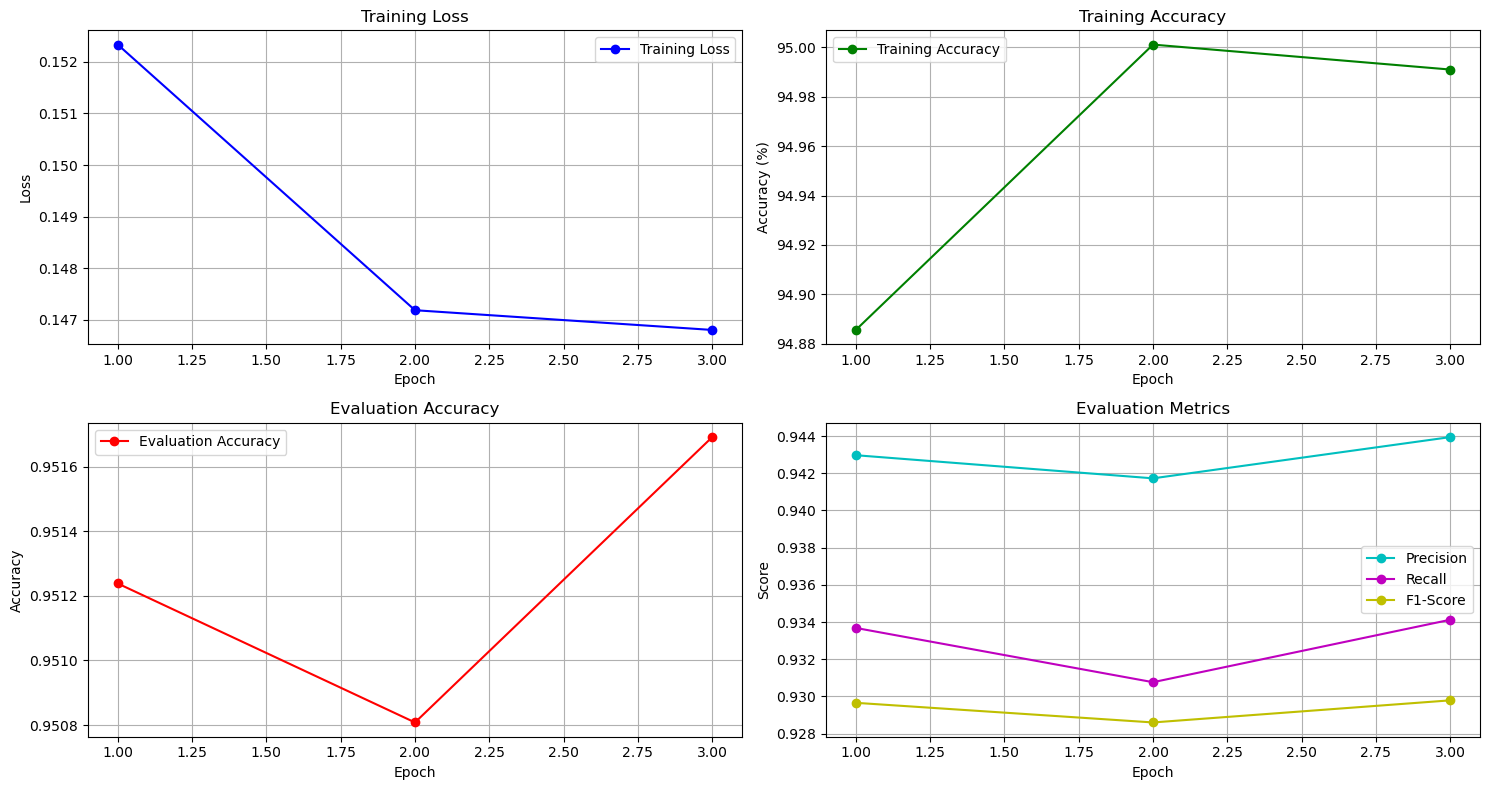

In [ ]:
# Create a figure for the plots
plt.figure(figsize=(15, 8))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='Training Loss', color='b')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')  # Save the training loss plot

# Plot training accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, marker='o', label='Training Accuracy', color='g')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')  # Save the training accuracy plot

# Plot evaluation accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, len(evaluation_accuracy) + 1), evaluation_accuracy, marker='o', label='Evaluation Accuracy', color='r')
plt.title('Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_accuracy.png')  # Save the evaluation accuracy plot

# Plot evaluation precision, recall, and F1-score
plt.subplot(2, 2, 4)
plt.plot(range(1, len(evaluation_precision) + 1), evaluation_precision, marker='o', label='Precision', color='c')
plt.plot(range(1, len(evaluation_recall) + 1), evaluation_recall, marker='o', label='Recall', color='m')
plt.plot(range(1, len(evaluation_f1) + 1), evaluation_f1, marker='o', label='F1-Score', color='y')
plt.title('Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_metrics.png')  # Save the evaluation metrics plot

# Adjust layout and show all plots
plt.tight_layout()
plt.show()


# Machine translation model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Data
data = [
    ("1 82 choque cardiogenico", "r570"),
    ("2 53 covid virus identificar", "u071"),
    ("2 52 acidosis metabólico", "e872"),
    ("1 57 infarto agudo miocardio", "i219"),
    ("1 63 insuficiencia respiratorio agudo", "j960"),
    ("1 49 hipertensión arterial", "i10x"),
    ("2 79 insuficiencia renal crónico", "n189"),
    ("2 69 síndrome dificultad respiratorio adulto", "j80x"),
    ("1 70 insuficiencia respiratorio hipoxemico", "j969"),
    ("2 64 choque séptico", "r572"),
]

# Tokenization and Encoding
def prepare_data(data):
    all_words = [word for cause, _ in data for word in cause.split()]
    word_counts = Counter(all_words)
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    word_to_idx = {word: idx + 2 for idx, word in enumerate(vocab)}  # Start indexing from 2
    word_to_idx['<PAD>'] = 0
    word_to_idx['<UNK>'] = 1

    # Encode labels
    label_encoder = LabelEncoder()
    labels = [causa_icd for _, causa_icd in data]
    label_encoder.fit(labels)
    
    return word_to_idx, label_encoder

word_to_idx, label_encoder = prepare_data(data)

class MedicalDataset(Dataset):
    def __init__(self, data, word_to_idx, label_encoder):
        self.data = data
        self.word_to_idx = word_to_idx
        self.label_encoder = label_encoder
        self.preprocess()
        
    def preprocess(self):
        self.cause_sequences = []
        self.causa_icd_sequences = []
        
        for cause, causa_icd in self.data:
            # Tokenize cause
            cause_tokens = [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in cause.split()]
            self.cause_sequences.append(torch.tensor(cause_tokens, dtype=torch.long))
            
            # Encode causa_icd
            causa_icd_encoded = self.label_encoder.transform([causa_icd])[0]
            self.causa_icd_sequences.append(causa_icd_encoded)
    
    def __len__(self):
        return len(self.cause_sequences)
    
    def __getitem__(self, idx):
        return self.cause_sequences[idx], self.causa_icd_sequences[idx]

# Custom collate function to pad sequences
def collate_fn(batch, pad_idx):
    causes, labels = zip(*batch)
    causes_padded = torch.nn.utils.rnn.pad_sequence(causes, batch_first=True, padding_value=pad_idx)
    labels = torch.tensor(labels, dtype=torch.long)
    return causes_padded, labels

dataset = MedicalDataset(data, word_to_idx, label_encoder)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: collate_fn(x, word_to_idx['<PAD>']))
test_loader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=lambda x: collate_fn(x, word_to_idx['<PAD>']))


In [ ]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_size, num_layers, num_classes, max_length=100):
        super(TransformerSeq2Seq, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_size)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(embed_size, num_classes)

    def forward(self, src):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        encoder_output = self.encoder(src.permute(1, 0, 2))
        encoder_output = encoder_output.mean(dim=0)  # Global average pooling
        output = self.decoder(encoder_output)
        return output

# Initialize model parameters
vocab_size = len(word_to_idx)
embed_size = 128
num_heads = 4
hidden_size = 256
num_layers = 2
num_classes = len(label_encoder.classes_)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerSeq2Seq(vocab_size, embed_size, num_heads, hidden_size, num_layers, num_classes).to(device)


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    
    # Lists to store metrics for each epoch
    training_losses = []
    training_accuracy = []
    evaluation_accuracy = []
    evaluation_precision = []
    evaluation_recall = []
    evaluation_f1 = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total = 0
        correct = 0
        epoch_loss = 0
        
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            
            outputs = model(src)
            
            # Compute loss
            loss = criterion(outputs, trg)
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            epoch_loss += loss.item() * trg.size(0)
            _, predicted = torch.max(outputs, 1)
            total += trg.size(0)
            correct += (predicted == trg).sum().item()
        
        # Average loss and accuracy for the epoch
        epoch_loss /= total
        epoch_accuracy = 100 * correct / total
        training_losses.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)
        
        # Evaluation phase
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for src, trg in test_loader:
                src, trg = src.to(device), trg.to(device)
                
                outputs = model(src)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(trg.cpu().numpy())
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        evaluation_accuracy.append(accuracy)
        evaluation_precision.append(precision)
        evaluation_recall.append(recall)
        evaluation_f1.append(f1)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.2f}, Training Accuracy: {epoch_accuracy:.2f}%, '
              f'Evaluation Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')
    
    return training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1

# Training settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Train and evaluate the model
training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1 = train_and_evaluate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)
